In [1]:
import numpy as np
import pandas as pd
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

# vanilla RNN
## IMDB

In [6]:
# imdb dataset from keras
from tensorflow.keras.datasets import imdb
# x_train, x_test의 max값을 10000으로 제한
max_features = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [7]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape, max(x_train.max())

((25000,), (25000,), (25000,), (25000,), 9995)

In [8]:
# 각 문서의 길이가 max_len보다 길면 자르고, 짧으면 0으로 padding
def pad_sequence(x, max_len):
    x = np.asarray(x)
    if len(x) < max_len:
        x = np.concatenate([np.zeros(max_len - len(x)), x])
    return x[len(x) - max_len:]

x_train_200 = np.array(list(map(lambda x:pad_sequence(x,200),x_train)))
x_test_200 = np.array(list(map(lambda x:pad_sequence(x,200),x_test)))


In [9]:
x_train_200.shape, x_test_200.shape, np.unique(y_train), np.unique(y_test)

((25000, 200), (25000, 200), array([0, 1]), array([0, 1]))

In [10]:
class simpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size1, hidden_size2, output_size):
        super(simpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size1, batch_first=True)
        self.fc1 = nn.Linear(hidden_size1, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.embedding(x)
        # x : (batch_size, seq_len, embedding_size)
        # x[:,-1,:] == h0[0,:,:]
        x, h0 = self.rnn(x)
        # sequence true mean, concat 등으로 바꿔 수행할 수 있음
        x = self.fc1(x[:, -1, :])
        x = self.tanh(x)
        x = self.fc2(x)
        return x

In [11]:
embedding = nn.Embedding(10000,64)(torch.Tensor(x_train_200).type(torch.long)[0:4])
print('embedding shape : ',embedding.shape)
rnn_reesult1,rnn_reesult2  = nn.RNN(64,32, batch_first=True)(embedding)
print('results shape : ',rnn_reesult1.shape, rnn_reesult2.shape)
print(rnn_reesult1[:,-1,:].equal(rnn_reesult2[0,:,:]))

embedding shape :  torch.Size([4, 200, 64])
results shape :  torch.Size([4, 200, 32]) torch.Size([1, 4, 32])
True


### 순수 pytorch

In [12]:
from sklearn.model_selection import train_test_split

x_train_200, x_valid_200, y_train, y_valid = train_test_split(x_train_200, y_train, test_size=0.1, random_state=42)

batch_size = 128
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train_200).type(torch.long), torch.Tensor(y_train).type(torch.long))
val_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_valid_200).type(torch.long), torch.Tensor(y_valid).type(torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_test_200).type(torch.long), torch.Tensor(y_test).type(torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
rnn = simpleRNN(10000, 64, 32, 16, 2)
rnn.to(device)

optimizer = torch.optim.RMSprop(rnn.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss().to(device)

In [20]:
rnn = simpleRNN(10000, 64, 32, 16, 2)
rnn.to(device)

optimizer = torch.optim.RMSprop(rnn.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss().to(device)

In [21]:
epochs = 20
for epoch in range(epochs):
    train_loss = 0
    train_correct = 0
    rnn.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = rnn(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss +=  loss.item() * inputs.size(0)
        train_correct += (outputs.argmax(1) == targets).sum().item()
    train_correct /= len(train_dataset)
    train_loss /= len(train_dataset)

    val_loss = 0
    val_correct = 0
    rnn.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = rnn(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == targets).sum().item()
    val_correct /= len(val_dataset)
    val_loss /= len(val_dataset)

    print(f'''Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_correct:.4f},Val Loss: {val_loss:.4f}, Val Acc: {val_correct:.4f}''')

Epoch 1/20, Train Loss: 0.6830, Train Acc: 0.5524,Val Loss: 0.6680, Val Acc: 0.5876
Epoch 2/20, Train Loss: 0.6347, Train Acc: 0.6319,Val Loss: 0.6185, Val Acc: 0.6524
Epoch 3/20, Train Loss: 0.5882, Train Acc: 0.6878,Val Loss: 0.5995, Val Acc: 0.6812
Epoch 4/20, Train Loss: 0.5436, Train Acc: 0.7277,Val Loss: 0.5696, Val Acc: 0.7056
Epoch 5/20, Train Loss: 0.5071, Train Acc: 0.7570,Val Loss: 0.5448, Val Acc: 0.7292
Epoch 6/20, Train Loss: 0.4848, Train Acc: 0.7726,Val Loss: 0.5280, Val Acc: 0.7472
Epoch 7/20, Train Loss: 0.4625, Train Acc: 0.7908,Val Loss: 0.5358, Val Acc: 0.7384
Epoch 8/20, Train Loss: 0.4355, Train Acc: 0.8060,Val Loss: 0.5100, Val Acc: 0.7616
Epoch 9/20, Train Loss: 0.4142, Train Acc: 0.8216,Val Loss: 0.4935, Val Acc: 0.7752
Epoch 10/20, Train Loss: 0.3937, Train Acc: 0.8315,Val Loss: 0.4931, Val Acc: 0.7740
Epoch 11/20, Train Loss: 0.3712, Train Acc: 0.8435,Val Loss: 0.4754, Val Acc: 0.7932
Epoch 12/20, Train Loss: 0.3543, Train Acc: 0.8541,Val Loss: 0.4809, Val A

In [18]:
rnn.eval()
test_correct = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = rnn(inputs)
        loss = criterion(outputs, targets)
        test_correct += (outputs.argmax(1) == targets).sum().item()
print('test acc : ', test_correct/len(test_dataset))

test acc :  0.81876


### skorch

In [25]:
from skorch import NeuralNetClassifier
from skorch.dataset import ValidSplit
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = NeuralNetClassifier(
                        simpleRNN(10000, 64, 32, 16, 2),
                        max_epochs=20,
                        lr = 0.0005,
                        batch_size = 128,
                        optimizer = torch.optim.RMSprop,
                        criterion = nn.CrossEntropyLoss,
                        device = device,
                        train_split = ValidSplit(10)
                        )

In [26]:
X_train_200 = np.r_[x_train_200, x_valid_200]
Y_train = np.r_[y_train, y_valid]

net.fit(torch.Tensor(X_train_200).type(torch.long),
        torch.Tensor(Y_train).type(torch.long))
print('completed')

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6829       0.5796        0.6679  1.7006
      2        0.6439       0.6476        0.6234  1.7312
      3        0.5891       0.6896        0.5846  1.7262
      4        0.5405       0.6384        0.6886  1.6567
      5        0.5029       0.7368        0.5334  1.6735
      6        0.4719       0.7456        0.5249  1.7192
      7        0.4439       0.6800        0.6408  1.6958
      8        0.4263       0.7796        0.4853  1.7166
      9        0.4023       0.7752        0.4862  1.7090
     10        0.3795       0.7784        0.5001  1.7131
     11        0.3644       0.7800        0.5039  1.6835
     12        0.3450       0.7792        0.5183  1.6883
     13        0.3533       0.7868        0.5009  1.6914
     14        0.3289       0.7884        0.5104  1.7111
     15        0.3044       0.8028        0.4838  1.6984
     16        0.3519       0.8


Bad key "text.kerning_factor" on line 4 in
/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


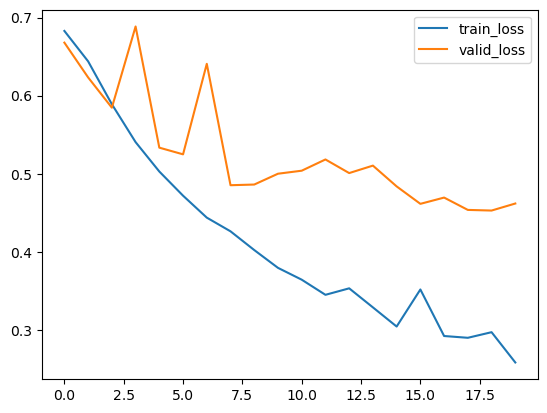

In [27]:
losses = {'train_loss' : [net.history[i]['train_loss'] for i in range(len(net.history))],
 'valid_loss' : [net.history[i]['valid_loss'] for i in range(len(net.history))] }
pd.DataFrame(losses).plot()

In [28]:
from sklearn.metrics import accuracy_score
y_pred = net.predict(torch.Tensor(x_test_200).type(torch.long))
accuracy_score(y_test, y_pred)

0.81312

# LSTM
## korean movie reviews_2016

In [3]:
with open('./Korean_movie_reviews_2016.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    # To read the second and third column info from each row
    texts, labels = zip(*docs)
    # 둘을 분리해서 별도의 list 변수로 저장

In [4]:
words_list = [doc.strip().split() for doc in texts]
print(words_list[:2])

[['부산', '행', '때문', '너무', '기대하고', '봤'], ['한국', '좀비', '영화', '어색하지', '않게', '만들어졌', '놀랍']]


In [5]:
# 빈도를 기준으로 상위 10000개의 단어들만 선택
total_words = np.concatenate(words_list)
unique_words, counts = np.unique(total_words, return_counts=True)
top_idx = counts.argsort()[::-1][:10000]
top_words = unique_words[top_idx]

In [6]:
# 인덱스 부여
top_words_dict = dict(zip(top_words, range(1, len(top_words)+1)))

In [7]:
def mapping_func(x):
    if x in top_words_dict:
        return top_words_dict[x]
    else: 
        pass
def mapping_func2list(x):
    return list(filter(None,map(mapping_func ,x)))
    
filtered_indexed_words = list(map(mapping_func2list, words_list))

In [8]:
# 각 문서의 길이가 max_len보다 길면 자르고, 짧으면 0으로 padding
def pad_sequence(x, max_len):
    x = np.asarray(x)
    if len(x) < max_len:
        x = np.concatenate([np.zeros(max_len - len(x)), x])
    return x[len(x) - max_len:]

X = np.array(list(map(lambda x:pad_sequence(x,200),filtered_indexed_words)))


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [24]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:,-1,:])
        return x

In [27]:
from skorch import NeuralNetClassifier
from skorch.dataset import ValidSplit
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = NeuralNetClassifier(
                        LSTM(10000+1, 32, 32, 2),
                        max_epochs=5,
                        lr = 0.001,
                        batch_size = 128,
                        optimizer = torch.optim.RMSprop,
                        criterion = nn.CrossEntropyLoss,
                        device = device,
                        train_split = None
                        )

In [28]:
net.fit(torch.Tensor(X_train).type(torch.long),
        torch.Tensor(y_train).type(torch.long))
print('completed')

  epoch    train_loss     dur
-------  ------------  ------
      1        0.4116  8.9085
      2        0.2944  8.9910
      3        0.2573  8.2667
      4        0.2355  8.9155
      5        0.2199  8.9203
completed


In [29]:
from sklearn.metrics import accuracy_score
y_pred = net.predict(torch.Tensor(X_test).type(torch.long))
accuracy_score(y_test, y_pred)

0.89488163981014

In [62]:
# reverse
top_words_dict_reverse = dict(zip(top_words_dict.values(), top_words_dict.keys()))
top_words_dict_reverse[0] = None
reverse = np.vectorize(lambda x: top_words_dict_reverse[x])
reversed = reverse(X_test[0])
reversed[reversed!=None]

array(['예진', '필모', '역대', '인생', '연기'], dtype=object)